In [23]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import json

# 접속 정보 로딩 (옵션: db-config.json 파일이 있을 경우)
path = '/Users/s/Desktop/ai/ex/project_2/db-config.json'

with open(path) as f:
    config = json.load(f)

user = config['user']
password = config['password']
host = config['host']
port = config['port']
database = config['database']

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}?charset=utf8mb4")

# air_quality_dataset 테이블 데이터 읽어오기
query = "SELECT * FROM air_quality_dataset"
df = pd.read_sql(query, con=engine)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime, timezone
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import io
import h5py
import tempfile
from datetime import datetime

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input
from sqlalchemy import create_engine, MetaData, Table, Column
from sqlalchemy import Integer, String, Text, DateTime, LargeBinary
import json
from sqlalchemy import create_engine 
from sqlalchemy.exc import SQLAlchemyError
import cryptography

In [25]:
df = df[['datetime', 'region', 'pm10', 'pm25']].copy()

In [26]:
meta_df = pd.DataFrame({'region': df['region'].unique()})

In [27]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Apple SD Gothic Neo'
matplotlib.rcParams['axes.unicode_minus'] = False

In [28]:
df['datetime'] = pd.to_datetime(df['datetime'])

# region + datetime을 인덱스로 설정
df = df.set_index(['region', 'datetime'])

# 🔥 지역별로 그룹을 유지한 채, 일자 기준 리샘플링
df = (
    df.groupby('region')
      .resample('1D', level='datetime')
      .max()
      .reset_index()
)

In [29]:
meta_df_yongsan = meta_df[meta_df['region'] == '용산구']

In [30]:
# 전처리 및 시퀀스 생성 함수
def create_sequences(data, window_size=48):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

def run_1year_forecast(df, region='용산구', pollutant='pm10'):
    def create_sequences(data, input_len=365, output_len=365):
        X, y = [], []
        for i in range(len(data) - input_len - output_len):
            X.append(data[i:i + input_len])
            y.append(data[i + input_len : i + input_len + output_len, 0])
        return np.array(X), np.array(y)

    # 날짜 처리 및 필터링
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    df_region = df[df['region'] == region]

    # 시계열 생성 및 보간
    series = df_region[pollutant].dropna().resample('D').mean().interpolate(method='spline', order=3).dropna()

    if len(series) < 800:
        print(f"[{region} - {pollutant}] 데이터 부족 (데이터 개수: {len(series)})")
        return

    # 정규화
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series.values.reshape(-1, 1))

    # 시퀀스 생성 (입력 365일 → 출력 365일)
    input_len = 365
    output_len = 365
    X, y = create_sequences(scaled, input_len, output_len)

    # 모델 구성
    model = Sequential([
        Input(shape=(input_len, 1)),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(output_len)
    ])
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    # 학습
    model.fit(X, y, epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)

    # 최근 365일 입력 기반 예측
    recent_input = scaled[-input_len:].reshape(1, input_len, 1)
    pred_scaled = model.predict(recent_input)[0]
    pred_inv = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

    # 시각화
    plt.figure(figsize=(14, 5))
    plt.plot(pred_inv, label='Forecasted PM10 (Next 365 days)', linewidth=2)
    plt.title(f"{region} ({pollutant.upper()}) - 향후 365일 예측 (입력: 최근 365일)")
    plt.xlabel("Days Ahead")
    plt.ylabel(pollutant.upper())
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, pred_inv

2025-07-03 13:02:05.209652: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-07-03 13:02:05.209740: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-03 13:02:05.209744: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1751515325.210036 25146075 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1751515325.210085 25146075 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2025-07-03 13:02:06.017039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
E0000 00:00:1751515326.023157 25146075 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0042
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0027
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0027
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0026
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0026
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0026
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0026
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0026
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0026
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0025
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0025
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0025
Epoch 13/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0025
Epoch 14/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0025
Epoch 15/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0025
E

E0000 00:00:1751515579.340033 25146075 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


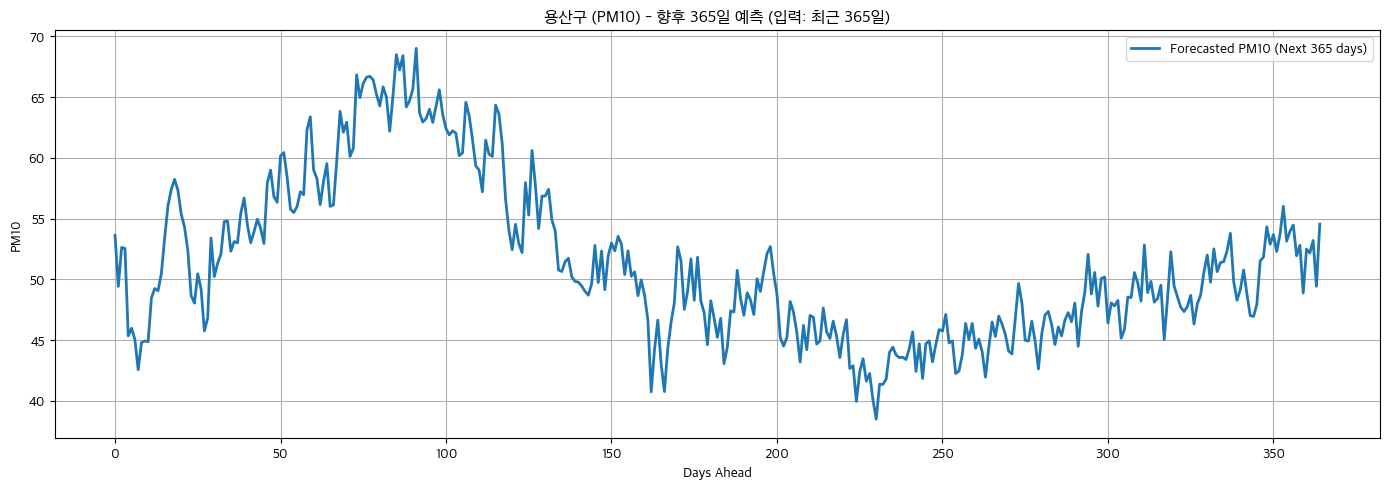

In [10]:
model, pred_inv = run_1year_forecast(df, region='용산구', pollutant='pm10')

In [13]:
def evaluate_model_on_2023(model, series, input_len=365, output_len=365):
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt
    import numpy as np

    # 보간 및 결측 제거
    series = series.dropna().resample('D').mean().interpolate(method='spline', order=3).dropna()

    if len(series) < input_len + output_len:
        print("⚠️ 입력 데이터 부족")
        return

    # 정규화
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series.values.reshape(-1, 1))

    # 최근 365일을 입력으로 사용
    recent_input = scaled[-input_len:].reshape(1, input_len, 1)
    pred_scaled = model.predict(recent_input)[0]
    pred_inv = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

    # 실제 2023년 데이터 추출
    actual_2023 = series['2023'].values
    if len(actual_2023) >= output_len:
        actual_2023 = actual_2023[:output_len]
        rmse = np.sqrt(mean_squared_error(actual_2023, pred_inv))
        print(f"📊 RMSE (예측 vs 실제 2023): {rmse:.2f}")

        # 시각화
        plt.figure(figsize=(14, 5))
        plt.plot(actual_2023, label='Actual 2023', linewidth=2)
        plt.plot(pred_inv, label='Predicted (Last 365d → Next 365d)', linewidth=2)
        plt.title(f"2023년 예측 vs 실제값 비교\nRMSE = {rmse:.2f}")
        plt.xlabel("Days in 2023")
        plt.ylabel("Value")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ 실제 2023년 데이터가 부족합니다.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📊 RMSE (예측 vs 실제 2023): 43.04


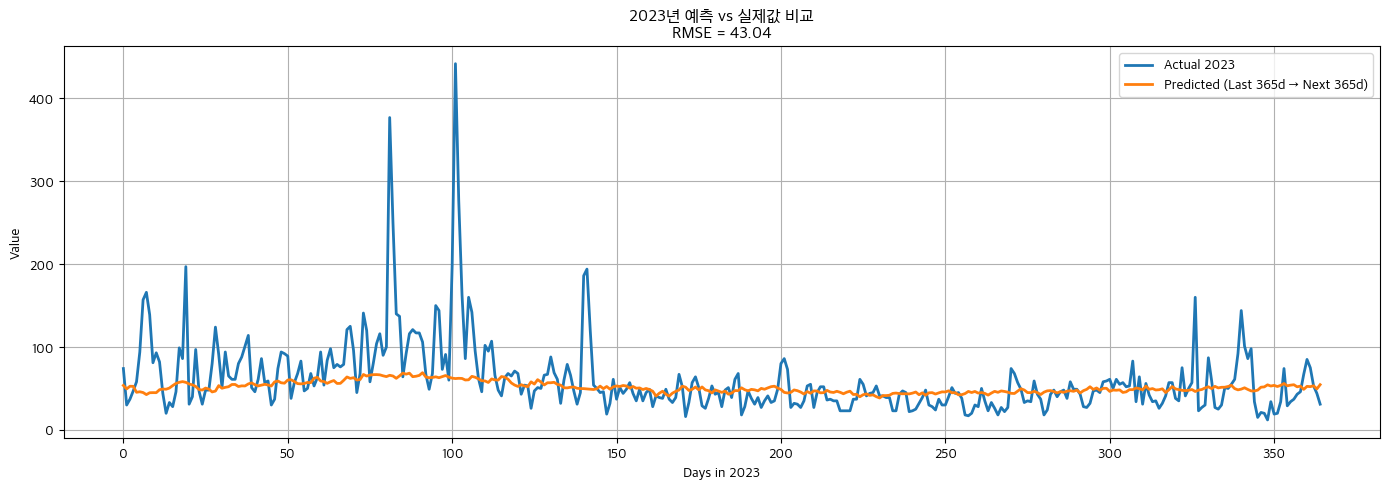

In [12]:
series = df[df['region'] == '용산구']['pm10']
evaluate_model_on_2023(model, series)

In [31]:
df['datetime'].max()

Timestamp('2025-07-02 00:00:00')

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, Reshape
from tensorflow.keras.callbacks import EarlyStopping

def run_forecast_and_compare_2025(df, region='용산구', pollutant='pm10'):
    def create_sequences(data, input_len=365, output_len=365, stride=30):
        X, y = [], []
        for i in range(0, len(data) - input_len - output_len, stride):
            X.append(data[i:i + input_len])
            y.append(data[i + input_len : i + input_len + output_len, 0])
        return np.array(X), np.array(y)

    # ✅ 날짜 컬럼 처리
    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)
    elif df.index.name != 'datetime':
        raise ValueError("datetime 컬럼이 없고, 인덱스도 datetime이 아님.")

    # ✅ 지역 필터링
    df_region = df[df['region'] == region]

    # ✅ 시계열 생성 및 보간
    series = df_region[pollutant].dropna().resample('D').mean().interpolate(method='spline', order=3).dropna()

    if len(series) < 800:
        print(f"[{region} - {pollutant}] 데이터 부족 (데이터 개수: {len(series)})")
        return

    # ✅ 로그 변환 → 정규화
    series_log = np.log1p(series)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series_log.values.reshape(-1, 1))

    # ✅ 시퀀스 생성
    input_len, output_len, stride = 365, 365, 30
    X, y = create_sequences(scaled, input_len, output_len, stride)
    X = X.reshape(-1, input_len, 1)

    # ✅ 모델 구성
    model = Sequential([
        Input(shape=(input_len, 1)),
        LSTM(64, return_sequences=True),
        LSTM(32, return_sequences=True),
        TimeDistributed(Dense(1)),
        Reshape((output_len,))
    ])
    model.compile(optimizer='adam', loss='mse')

    # ✅ EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

    # ✅ 학습
    model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)

    # ✅ 예측: 최근 365일 → 향후 365일
    recent_input = scaled[-input_len:].reshape(1, input_len, 1)
    pred_scaled = model.predict(recent_input)[0]
    pred_log = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
    pred_final = np.expm1(pred_log)

    # ✅ 예측 날짜: 2024-07-03 ~ 2025-07-02
    forecast_start_date = pd.Timestamp('2024-07-03')
    forecast_dates = pd.date_range(start=forecast_start_date, periods=output_len, freq='D')
    pred_series = pd.Series(pred_final, index=forecast_dates)

    # ✅ 실제값 추출
    actual_series = series[forecast_start_date:forecast_start_date + pd.Timedelta(days=output_len - 1)]

    # ✅ 시각화
    plt.figure(figsize=(16, 5))
    if len(actual_series) == output_len:
        plt.plot(actual_series.index, actual_series.values, label='Actual (2024-07~2025-07)')
        plt.plot(pred_series.index, pred_series.values, label='Predicted', linewidth=2)
        rmse = np.sqrt(np.mean((actual_series.values - pred_series.values) ** 2))
        plt.title(f"{region} {pollutant.upper()} 예측 vs 실제값\n(2024-07-03 ~ 2025-07-02)\nRMSE = {rmse:.2f}")
    else:
        plt.plot(pred_series.index, pred_series.values, label='Predicted (Next 365 days)', linewidth=2)
        plt.title(f"{region} {pollutant.upper()} - 향후 365일 예측 (실제값 부족)")
    
    plt.xlabel("Date")
    plt.ylabel(pollutant.upper())
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, pred_final, forecast_dates

Epoch 1/100


E0000 00:00:1751516636.125010 25146075 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 7s/step - loss: 0.1349 - val_loss: 0.0323
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0273 - val_loss: 0.0296
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0320 - val_loss: 0.0259
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 829ms/step - loss: 0.0229 - val_loss: 0.0118
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 752ms/step - loss: 0.0139 - val_loss: 0.0147
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 943ms/step - loss: 0.0175 - val_loss: 0.0160
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 870ms/step - loss: 0.0181 - val_loss: 0.0133
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 831ms/step - loss: 0.0148 - val_loss: 0.0113
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 707ms/step - loss: 0.0128 - val_loss: 0.0122
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 717ms/step - loss: 0.0136 - val_loss: 0.0131
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 953ms/step - loss: 0.0142 - val_loss: 0.0123
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 737ms/step - loss: 0.0135 - val_loss: 0.01

E0000 00:00:1751516854.355833 25146075 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


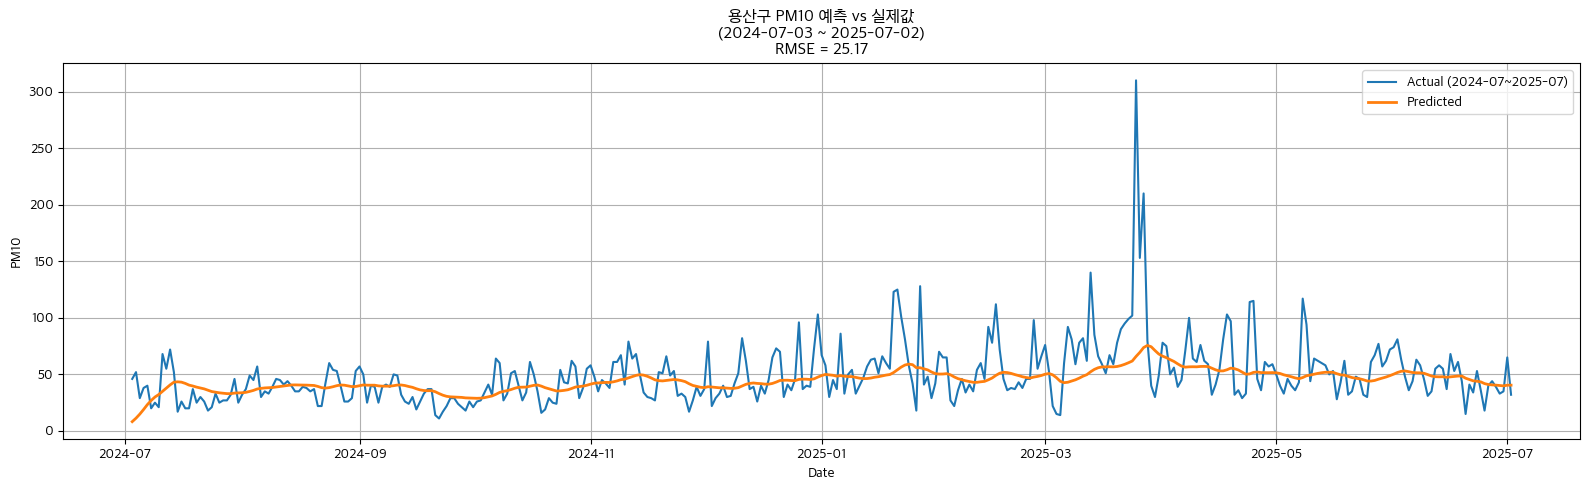

In [37]:
model, pred, dates = run_forecast_and_compare_2025(df, region='용산구', pollutant='pm10')

Epoch 1/100


E0000 00:00:1751518094.598216 25146075 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


3/3 ━━━━━━━━━━━━━━━━━━━━ 33s 7s/step - loss: 0.2953 - val_loss: 0.1391
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.1284 - val_loss: 0.0386
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0374 - val_loss: 0.0343
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0439 - val_loss: 0.0388
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0392 - val_loss: 0.0206
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0240 - val_loss: 0.0222
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0276 - val_loss: 0.0255
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0306 - val_loss: 0.0235
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0275 - val_loss: 0.0200
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0241 - val_loss: 0.0194
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0235 - val_loss: 0.0208
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0245 - val_loss: 0.0207
Epoch 13/100
3/3 ━━━━━━━

E0000 00:00:1751518440.842479 25146075 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


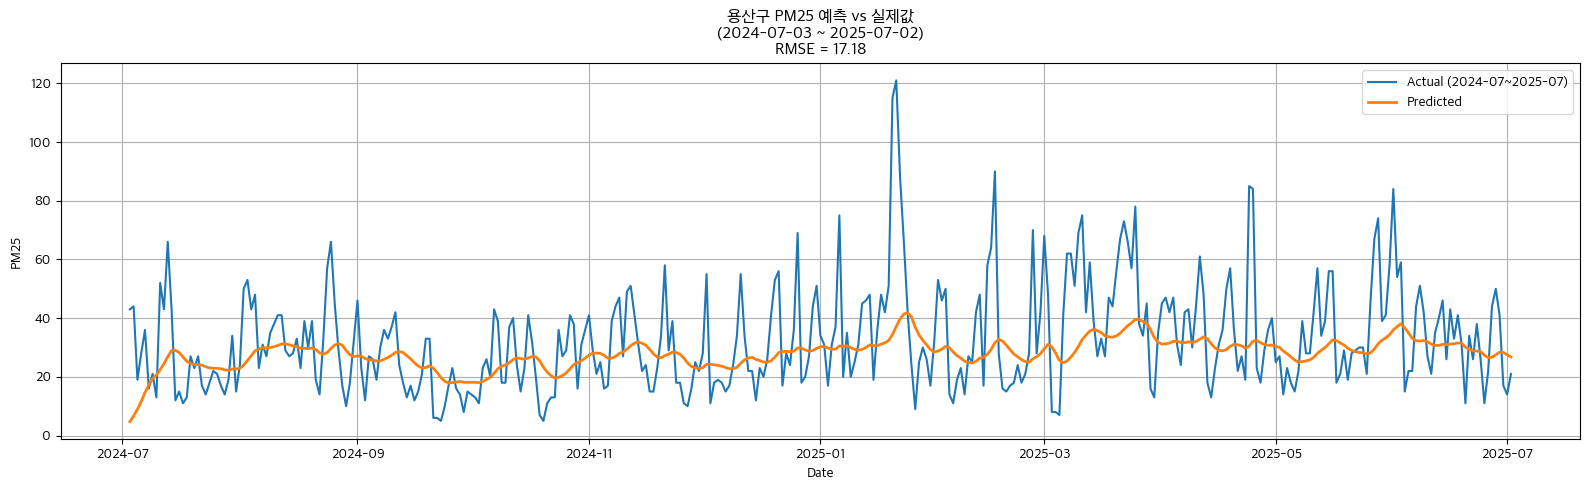

In [47]:
model2, pred2, dates2 = run_forecast_and_compare_2025(df, region='용산구', pollutant='pm25')

In [43]:
from datetime import datetime, timezone, timedelta
import tempfile
from sqlalchemy import MetaData, Table

# SQLAlchemy metadata 및 테이블 로드
metadata = MetaData()
models_table = Table('models', metadata, autoload_with=engine)

# KST 기준 시간
KST = timezone(timedelta(hours=9))

# ✅ 단일 모델 저장
with tempfile.NamedTemporaryFile(suffix=".h5", delete=True) as tmp:
    model.save(tmp.name)
    tmp.seek(0)
    model_binary = tmp.read()

# ✅ DB 저장
with engine.connect() as conn:
    conn.execute(models_table.insert().values(
        name="lstm_pm10_yongsan",  # 원하는 이름 지정
        type="LSTM",
        version="v5.0",
        description=f"단변량 모델",
        created_at=datetime.now(KST),
        data=model_binary
    ))
    conn.commit()

print("✅ 단일 모델이 DB에 성공적으로 저장되었습니다.")

✅ 단일 모델이 DB에 성공적으로 저장되었습니다.


In [48]:
from datetime import datetime, timezone, timedelta
import tempfile
from sqlalchemy import MetaData, Table

# SQLAlchemy metadata 및 테이블 로드
metadata = MetaData()
models_table = Table('models', metadata, autoload_with=engine)

# KST 기준 시간
KST = timezone(timedelta(hours=9))

# ✅ 단일 모델 저장
with tempfile.NamedTemporaryFile(suffix=".h5", delete=True) as tmp:
    model2.save(tmp.name)
    tmp.seek(0)
    model_binary = tmp.read()

# ✅ DB 저장
with engine.connect() as conn:
    conn.execute(models_table.insert().values(
        name="lstm_pm10_yongsan",  # 원하는 이름 지정
        type="LSTM",
        version="v5.0",
        description=f"단변량 모델",
        created_at=datetime.now(KST),
        data=model_binary
    ))
    conn.commit()

print("✅ 단일 모델이 DB에 성공적으로 저장되었습니다.")

✅ 단일 모델이 DB에 성공적으로 저장되었습니다.


In [41]:
'''
from datetime import datetime, timezone, timedelta
import tempfile
from sqlalchemy import MetaData, Table

# SQLAlchemy metadata 및 모델 테이블 로드
metadata = MetaData()
models_table = Table('models', metadata, autoload_with=engine)

# 대상 오염물질 설정
target = 'pm10'
target_cols = [target]  # 필요 시 확장 가능

# 지역별 모델 저장
for region, content in model.items():
    lstm_model = content['model']  # 이름 변경 (model 덮어쓰기 방지)

    # ✅ 임시 파일에 저장 후 바이너리로 읽기
    with tempfile.NamedTemporaryFile(suffix=".h5", delete=True) as tmp:
        lstm_model.save(tmp.name)
        tmp.seek(0)
        model_binary = tmp.read()

    # ✅ DB에 이진 데이터 저장
    with engine.connect() as conn:
        KST = timezone(timedelta(hours=9))
        conn.execute(models_table.insert().values(
            name=f"lstm_{target}_{region}",
            type="LSTM",
            version="v5.0",
            description=f"Features: {', '.join(feature_cols)}",
            created_at=datetime.now(KST),
            data=model_binary
        ))
        conn.commit()

print("✅ 모든 지역 모델이 DB에 저장되었습니다.")
'''

'\nfrom datetime import datetime, timezone, timedelta\nimport tempfile\nfrom sqlalchemy import MetaData, Table\n\n# SQLAlchemy metadata 및 모델 테이블 로드\nmetadata = MetaData()\nmodels_table = Table(\'models\', metadata, autoload_with=engine)\n\n# 대상 오염물질 설정\ntarget = \'pm10\'\ntarget_cols = [target]  # 필요 시 확장 가능\n\n# 지역별 모델 저장\nfor region, content in model.items():\n    lstm_model = content[\'model\']  # 이름 변경 (model 덮어쓰기 방지)\n\n    # ✅ 임시 파일에 저장 후 바이너리로 읽기\n    with tempfile.NamedTemporaryFile(suffix=".h5", delete=True) as tmp:\n        lstm_model.save(tmp.name)\n        tmp.seek(0)\n        model_binary = tmp.read()\n\n    # ✅ DB에 이진 데이터 저장\n    with engine.connect() as conn:\n        KST = timezone(timedelta(hours=9))\n        conn.execute(models_table.insert().values(\n            name=f"lstm_{target}_{region}",\n            type="LSTM",\n            version="v5.0",\n            description=f"Features: {\', \'.join(feature_cols)}",\n            created_at=datetime.now(KST),\n          